In [ ]:
import os
import glob
import cloudpickle
from PIL import Image, ImageEnhance
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

!pip install kornia
from kornia.color.lab import rgb_to_lab, lab_to_rgb
from zipfile import ZipFile

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings('ignore')

# 1. Load data

Обычно фотографии представляются в формате RGB, но этот формат неудобен для задачи Colorization т.к придется предсказывать для каждого пикселя сразу три числа. Давайте будем преобразовывать фото в другой формат, LAB, в котором первая компонента l отвечает за яркость изображения(т.е. является чб изображением).  И поэтому нам остается предсказать не три компоненты, а две(a, b), что гораздо проще.

[_**Датасет с картинками**_](https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset) 


In [2]:
with ZipFile('/content/gdrive/MyDrive/images.zip', 'r') as file:
  file.extractall('/content/')

In [3]:
class Dataset(Dataset):
    def __init__(self, dataset_path, transforms=None, device='cuda:0'):
        self.paths = glob.glob(dataset_path)
        self.transforms = transforms

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]
        image = Image.open(img_name)
        

        if self.transforms:
            image = self.transforms(image).to(device)
        
        lab = rgb_to_lab(image)
    
        return image, lab[0:1, :, :] / 100, lab[1:, :, :] / 128

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

image_size = 256

DATA_DIR = '/content/data/'

train_data = Dataset(DATA_DIR + 'train_color/*.jpg',
                       transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((image_size, 
                                                              image_size)),
                                           transforms.RandomHorizontalFlip()]), device)

print(len(train_data))

test_data = Dataset(DATA_DIR + 'test_color/*.jpg',
                       transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((image_size, 
                                                              image_size))]), device)
print(len(test_data))

batch_size = 16

train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

5000
739


torch.Size([16, 3, 256, 256])


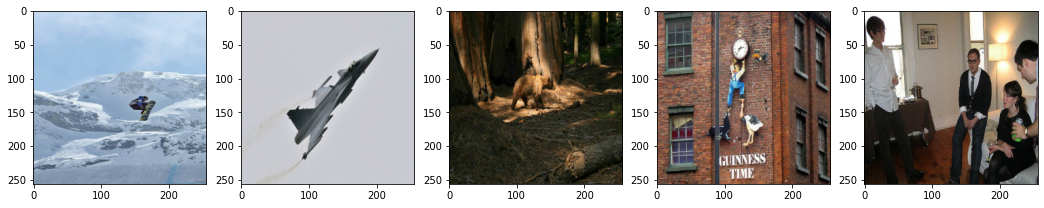

In [5]:
photo_test = next(iter(train_loader))[0].cpu()
print(photo_test.shape)

plt.figure(figsize=(18, 6))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.rollaxis(photo_test[i].numpy(), 0, 3))



plt.show()

# 2. Modeling

Для раскраски изображений я буду использовать архитектуру GAN. 

Идею взял с этого [_**блокнота**_](https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb)

План такой:

1. На основе предобученной resnet18 создаем UNET и обучаем 20 эпох с L1Loss. 

2. После создаем pix2pix GAN который также обучаем 20 эпох. В качестве Generator возьмем модель с прошлого шага. А дискриминатор объявим как обычный PatchDiscriminator который используется в моделям pix2pix. 

## 2.1 Unet

In [ ]:
!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

# create unet 
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [6]:
# utility functions

folder = '/content/gdrive/MyDrive/color_image_gan/'

if not os.path.isdir(folder):
    os.mkdir(folder)

def save_samples(epochs, X, y, images):
    fake_fname = f'epoch_{epochs}.png'
    X = X.cpu().detach()
    y = y.cpu().detach()
    images = images.cpu().detach()
    X, y = convert_to_rgb(X, y)
    save_image(torch.cat([X, y, images], axis=0), folder + fake_fname, nrow=5)

def convert_to_rgb(X, y):
    y = lab_to_rgb(torch.cat([X * 100, y * 128], axis=1))
    X = lab_to_rgb(torch.cat([X * 100, torch.zeros_like(X), torch.zeros_like(X)], axis=1))
    return X, y

def test_gen(gen, val, epoch):
    with torch.no_grad():
        gen.eval()
        images, X, y = next(iter(val))
        images, X, y = images[:5], X[:5], y[:5]
        y_pred = gen(X)
        save_samples(f'{epoch}', X, y_pred, images)
        gen.train()

def save_gen(gen):
    torch.save(gen, f'/content/gdrive/MyDrive/colorization_models/pretrained_unet_res.pt')

In [14]:
def pretrain_gen(gen, data, data_val, loss_func, opt, num_epochs):
    losses = []
    for epoch in range(1, num_epochs + 1):
        epoch_losses = []
        for image, X, y in tqdm(data):
            gen.zero_grad()

            y_pred = gen(X)
            loss = loss_func(y, y_pred)
            loss.backward()
            opt.step()

            epoch_losses.append(loss.item())

         
        test_gen(gen, data_val, epoch)
        save_gen(gen)
        losses.append(np.mean(epoch_losses))
        print(f'Epoch {epoch}: {losses[-1]}')
        

    return losses

In [ ]:
lr = 1e-4
num_epochs = 20
gen = build_res_unet()
opt = torch.optim.Adam(gen.parameters(), lr=lr)
loss_func = nn.L1Loss()
history = pretrain_gen(gen, train_loader, test_loader, loss_func, opt, num_epochs)


## 2.2 GAN

In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x, y):
        return self.model(torch.cat([x, y], axis=1))

In [8]:
def train_discr(gen, discr, X, y, loss_func, opt):
    opt.zero_grad()

    real_preds = discr(X, y)
    real_targets = torch.ones((real_preds.size(0), 1, 30, 30), device=device)
    real_loss = loss_func(real_preds, real_targets)
    cur_real_score = torch.mean(real_preds).item()
    
    fake_images = gen(X)
    fake_targets = torch.zeros(fake_images.size(0), 1, 30, 30, device=device)
    fake_preds = discr(X, fake_images)
    fake_loss = loss_func(fake_preds, fake_targets)
    cur_fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt.step()

    return loss.item(), cur_real_score, cur_fake_score

def train_gen(gen, discr, data, loss_func, opt):
    _, X, y = data
    opt.zero_grad()
    # Generate fake images
    fake_images = gen(X)
    
    # Try to fool the discriminator
    preds = discr(X, fake_images)
    targets = torch.ones(preds.size(0), 1, 30, 30, device=device)
    loss = loss_func(preds, targets) + 100*nn.functional.l1_loss(y, fake_images)
    
    # Update generator weights
    loss.backward()
    opt.step()

    return loss.item()

In [9]:
def save_models(epoch):
        torch.save(gen, f'/content/gdrive/MyDrive/colorization_models/gen_{epoch}.pt')
        torch.save(discr, f'/content/gdrive/MyDrive/colorization_models/discr_{epoch}.pt')

In [10]:
def train_GAN(gen, discr, data, val, loss_func, opt_gen, opt_discr, num_epochs):
    losses_g = []
    losses_d = []


    for epoch in range(num_epochs):
        print('Epoch', epoch + 1)

        gen.train()
        discr.train()
        loss_g_per_epoch = []
        loss_d_per_epoch = []

        
        gen_data = iter(data)

        for _, X, y in tqdm(data):
            loss_d, real_score, fake_score = train_discr(gen, discr, X, y, loss_func, opt_discr)
            loss_g = train_gen(gen, discr, next(gen_data), loss_func, opt_gen)

            loss_g_per_epoch.append(loss_g)
            loss_d_per_epoch.append(loss_d)

                
            # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
            
        test_gen(gen, val, str(epoch) + '_gan')
        save_models(epoch)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(epoch + 1, num_epochs, losses_g[-1], losses_d[-1]))
        

    gen.eval()
    discr.eval()
    return losses_g, losses_d

In [ ]:
lr = 2e-4 
num_epochs = 20

beta1, beta2 = 0.5, 0.999

gen = torch.load('/content/gdrive/MyDrive/colorization_models/pretrained_unet_res.pt',
                 map_location=device)

discr = PatchDiscriminator(3).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))
opt_discr = torch.optim.Adam(discr.parameters(), lr=lr, betas=(beta1, beta2))

history = train_GAN(gen, discr, train_loader, test_loader, nn.BCEWithLogitsLoss(), opt_gen, opt_discr, num_epochs)

## 2.3 Save model

In [13]:
gen = gen.cpu()

transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((image_size, 
                                                              image_size))])

to_pil = transforms.ToPILImage()


def predict(src, path): 
    """Принимает путь до чб изображения. 
    Обрабатывает это изображение и сохраняет как path""" 

    black_img = Image.open(src).convert('L')
    small_img = transform(black_img)
    lab = rgb_to_lab(torch.cat([small_img, torch.zeros_like(small_img),
                                torch.zeros_like(small_img)], axis=0))
    y = gen(lab[0:1, :, :][np.newaxis, :, :] / 100)[0]
    color_image = lab_to_rgb(torch.cat([lab[0:1, :, :], y * 128], axis=0))

    # resize photo
    size = black_img.size
    coef = image_size / size[0]  
    result_image = to_pil(color_image).resize((int(size[0]*coef), int(size[1]*coef)))
    result_image = result_image.convert('RGB')

    # Добавляем яркости
    enhancer = ImageEnhance.Brightness(result_image)
    result_image = enhancer.enhance(2.5)
    result_image.save(path) 


In [14]:
# Сохраняем функцию со всеми зависимостями для дальнейшего использования
data = {'predict_func': predict}

with open('/content/gdrive/MyDrive/colorization_models/final_model.bin', 'wb') as file:
    cloudpickle.dump(data, file)

# 3. Testing model

Смотрим как модель раскрасит случайные фото из интернета

In [2]:
with open('/content/gdrive/MyDrive/colorization_models/final_model.bin', 'rb') as file:
    predict = cloudpickle.load(file)['predict_func']

In [3]:
black = glob.glob('/content/gdrive/MyDrive/Test/*')

folder = '/content/gdrive/MyDrive/photo_color/'

if not os.path.isdir(folder):
    os.mkdir(folder)

for i, p in enumerate(black):
    predict(p, f'{folder}{i}.jpg')

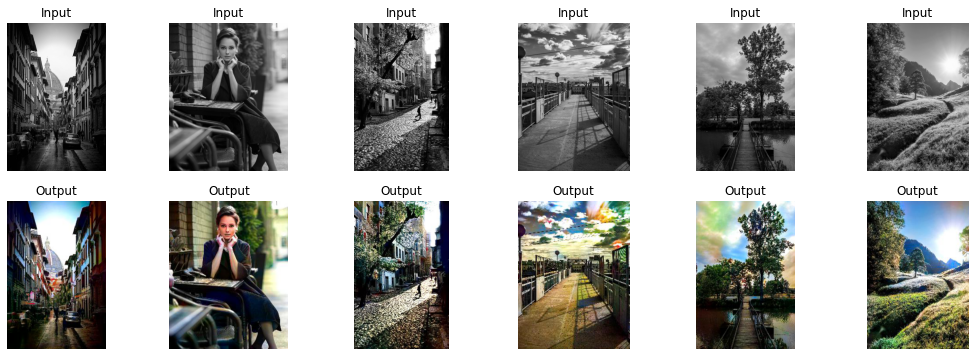

In [4]:
color = glob.glob(folder + '*')

plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.title('Input')
    plt.axis(False)
    plt.imshow(Image.open(black[i]), cmap='gray')

    plt.subplot(2, 6, i+7)
    plt.title('Output')
    plt.axis(False)
    plt.imshow(Image.open(color[i]))


plt.show()